# Data Preprocessing

The following file contains the code for preprocessing the data.

Make sure to create a directory "data/cleaned_data/" and "data/fully_preprocessed_data/" such that the data can be saved there. Besides, save the fasttext file of https://fasttext.cc/docs/en/english-vectors.html (choosing wiki news - 1 million word vectors) under "data/fasttext_file/wiki-news-300d-1M.vec".

## Importing libraries

In [498]:
# imports
# deprecation warning might appear for collections library, however meaningless for python version 3.7.7
import os
import re
import glob
import nltk
import h5py
import collections
import numpy as np
import pandas as pd
import pickle as pkl
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing import sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt

nltk.download('punkt')
#nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Cleaning

In [499]:
# create the stopwords list
stopwords = stopwords.words('english')
stopwords_keep =['no', 'not', 'nor']
stopwords = list(set(stopwords).difference(set(stopwords_keep)))

# set the lemmatizer
lemmatizer = WordNetLemmatizer()

In [500]:
# function for data cleaning
def data_cleaning(df):
    
    # handle contracted words
    df['text'] = df['text'].apply(lambda x: ' '.join(['can' if word == 'ca' else word for word in str(x).split()]))
    df['text'] = df['text'].apply(lambda x: ' '.join(['will' if word == 'wo' else word for word in str(x).split()]))
    df['text'] = df['text'].apply(lambda x: ' '.join(['shall' if word == 'sha' else word for word in str(x).split()]))
    df['text'] = df['text'].apply(lambda x: ' '.join(['not' if word == 'nt' or word == "n't" else word for word in str(x).split()]))
    
    # remove punctuation & special characters
    df['text'] = df['text'].apply(lambda x: ' '.join(re.split('\W+', x)))
    df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word.isalnum()))
   
    # remove nouns and numbers
    df['text'] = df['text'].astype(str).apply(lambda x: nltk.tag.pos_tag(x.split()))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word, tag in x if tag != 'CD']))
    # remove stopwords
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
    
    # lemmatize
   # df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    print(df)
    return df

In [501]:
# function for loading and cleaning the data using the data_cleaning() function
def load_and_clean(path):
    
    # load the data into one data frame, create a domain columns that indicates the domain by using the filename
    df_list = []
    for file_name in glob.glob(path):
        df_temp = pd.read_csv(file_name, delimiter = '\t', names=["label","text"], encoding='latin-1')
        df_temp['domain'] = os.path.basename(file_name)
        df_list.append(df_temp)    
    df = pd.concat(df_list, ignore_index = True)
    
    # clean the data
    df = data_cleaning(df)
    
    # delete empty strings
    df['text'].replace('', np.nan, inplace=True)
    df.dropna(subset=['text'], inplace=True)
    
    return df

In [502]:
# function for loading and cleaning the data using the data_cleaning() function
def load_and_clean2(path):
    
    # load the data into one data frame, create a domain columns that indicates the domain by using the filename
    df_list = []
    for file_name in glob.glob(path):
        df_temp = pd.read_csv(file_name, delimiter = '\t', names=["text"], encoding='latin-1')
        df_temp['domain'] = os.path.basename(file_name)
        df_list.append(df_temp)    
    df = pd.concat(df_list, ignore_index = True)
    
    # clean the data
    df = data_cleaning(df)
    
    # delete empty strings
    df['text'].replace('', np.nan, inplace=True)
    df.dropna(subset=['text'], inplace=True)
    
    return df

In [503]:
# load and clean the train and test data
df_train = load_and_clean('data/uncleaned_data/train/*')
df_test = load_and_clean('data/uncleaned_data/test/*')
df_unlabel = load_and_clean2('data/uncleaned_data/unlabelled/*')
# delete "task.train" or "task.text" such that the column domain just shows the domain
#df_train['domain'] = [re.sub('.task.train$', '', word) for word in np.array(df_train['domain'])]
#df_test['domain'] = [re.sub('.task.test$', '', word) for word in np.array(df_test['domain'])]
#df_unlabel['domain'] = [re.sub('.task.unlabel$', '', word) for word in np.array(df_unlabel['domain'])]

       label                                               text  \
0          1  bourne ultimatum review thrilling set get fina...   
1          1  hollow man starts brilliant flawed scientist d...   
2          1  since title english imdb lists show primary la...   
3          0  oh dear englishman small part welsh fan anthon...   
4          1  following sitcom plot mindlessly easy characte...   
...      ...                                                ...   
25375      1  recived paint quickly great condition bad ball...   
25376      1  originally bought blue lb red lb black lb grip...   
25377      0  rarely get taken time song played times no ins...   
25378      1  bought neighbors little girl loved easy put to...   
25379      0  well first ordered product amazon sent somethi...   

                           domain  
0                 imdb.task.train  
1                 imdb.task.train  
2                 imdb.task.train  
3                 imdb.task.train  
4              

In [504]:
df_train['domain'] = [re.sub('.task.train$', '', word) for word in np.array(df_train['domain'])]
df_test['domain'] = [re.sub('.task.test$', '', word) for word in np.array(df_test['domain'])]
df_unlabel['domain'] = [re.sub('.task.unlabel$', '', word) for word in np.array(df_unlabel['domain'])]

In [505]:
df_unlabel["label"]=3

In [506]:
#df_train2 = df_train[["text", "domain"]]
#df_train["label_id"]=1
#df_unlabel["label_id"]=0
df_merged = pd.concat([df_train, df_unlabel], ignore_index=True)

In [332]:
df_train.shape

(25380, 4)

In [333]:
df_test.shape

(6400, 4)

In [507]:
# save cleaned data to files
pkl.dump(df_train, open("data/cleaned_data/train_cleaned.p", "wb"))
pkl.dump(df_test, open("data/cleaned_data/test_cleaned.p", "wb"))
pkl.dump(df_merged, open("data/cleaned_data/merged_cleaned.p", "wb"))

## Setting the sequence length and vocabulary size

In [ ]:
# part of the code below in this file originates from the following book:
# Gulli, Antonio, Amita Kapoor, and Sujit Pal. Deep Learning with TensorFlow 2 and Keras: Regression, ConvNets, GANs, RNNs, NLP, and More with TensorFlow 2 and the Keras API. Packt Publishing, Limited, 2019, pp. 365-373.

In [508]:
# open cleaned train and test data (if the previous cells were executed a different time)
with open('data/cleaned_data/train_cleaned.p', 'rb') as f:
    df_train = pkl.load(f)
with open('data/cleaned_data/test_cleaned.p', 'rb') as f:
    df_test = pkl.load(f)
with open('data/cleaned_data/merged_cleaned.p', 'rb') as f:
    df_merged = pkl.load(f)
    
# loading the unknown token for future use
with open('unk_token.p', 'rb') as f:
    unk = pkl.load(f)

In [99]:
df_merged

,label,text,domain,idx_domain
0,1,bourne ultimatum 2007 review thrilling set two...,imdb,0
1,1,hollow man starts brilliant flawed scientist d...,imdb,1
2,1,since title english imdb lists show primary la...,imdb,2
3,0,oh dear englishman small part welsh fan anthon...,imdb,3
4,1,following sitcom plot mindlessly easy characte...,imdb,4
...,...,...,...,...
55819,3,After reading reviews nearly every wipe warmer...,baby,3495
55820,3,LAs bases para mantener un mamon esteril son f...,baby,3496
55821,3,I used bottles first son wonderful They never ...,baby,3497
55822,3,Okay first I get babiesrus wanted charge arm l...,baby,3498


In [509]:
# prepare the data: nummerate instances (to know which instances were the orginal ones after shuffling before the autoencoder) 
# and create a dictionary that numerically encodes the domain 

# nummerate each instance for each domain
df_train['idx_domain'] = df_train.groupby(['domain']).cumcount()
df_test['idx_domain'] = df_test.groupby(['domain']).cumcount()
df_merged['idx_domain'] = df_merged.groupby('domain').cumcount()
# create a dictionary that numerically encodes the domain
dict_domain = dict(zip(sorted(set(np.array(df_train['domain']))), np.arange(16)))
#dict_domain = dict(zip(sorted(set(np.array(df_merged['domain']))), np.arange(16)))
display(dict_domain)

{'MR': 0,
 'apparel': 1,
 'baby': 2,
 'books': 3,
 'camera_photo': 4,
 'dvd': 5,
 'electronics': 6,
 'health_personal_care': 7,
 'imdb': 8,
 'kitchen_housewares': 9,
 'magazines': 10,
 'music': 11,
 'software': 12,
 'sports_outdoors': 13,
 'toys_games': 14,
 'video': 15}

In [510]:
df_merged["idx_domain"]= df_merged["idx_domain"].astype('Int64')

In [138]:
#df_merged.head(2000)

In [511]:
# divides the data of the data frame into reviews, labels, domain and instance number
def divide_data(df, dict_domain):
    
    reviews = np.array([s for s in df['text']])
    X ,y, domain, idx_domain = reviews, np.array(df['label']), np.array(df['domain']), np.array(df['idx_domain'])
    domain = [dict_domain.get(c, c) for c in domain]
       
    return X, y, domain, idx_domain

In [512]:
# divides the data of the data frame into reviews, labels, domain and instance number
def divide_data2(df, dict_domain):
    
    reviews = np.array([s for s in df['text']])
    X, y, domain, idx_domain= reviews, np.array(df['label']), np.array(df['domain']), np.array(df['idx_domain'])
    domain = [dict_domain.get(c, c) for c in domain]
       
    return X, y, domain, idx_domain

In [513]:
# divide train and test data such that the reviews, labels, domain and instance number are separated
X_train, y_train, domain_train, idx_domain_train = divide_data(df_train, dict_domain)
X_test, y_test, domain_test, idx_domain_test = divide_data(df_test, dict_domain)

In [514]:
X_merged, y_merged, domain_merged, idx_domain_merged= divide_data(df_merged, dict_domain)

In [515]:
# parse training instances into one list called parsed_reviews_train
# and count the number of words per review in the list nr_words_train (needed when determining the vocabulary size and sequence length)

word_freqs_merged = collections.Counter()
nr_words_merged = []
parsed_reviews_merged = []

# loop over the different reviews and tokenize the words
for review in X_merged:
    words = nltk.word_tokenize(review)
    parsed_words_merged = []
    
    # for each review count word frequencies and parse words
    for word in words:
        word_freqs_merged[word] += 1
        parsed_words_merged.append(word)
      
    # append the number of words in each review, append the parsed reviews
    nr_words_merged.append(len(words))      
    parsed_reviews_merged.append(" ".join(parsed_words_merged))

In [96]:
len(parsed_reviews_merged)

55824

In [516]:
# parse test instances into one list called parsed_reviews_test
# and count the number of words per review into the list nr_words_esz
parsed_reviews_test = []
nr_words_test = []
for review in X_test:
    words = nltk.word_tokenize(review)
    parsed_words = []
    
    for word in words:
        parsed_words.append(word)
        
    nr_words_test.append(len(words))  
    parsed_reviews_test.append(" ".join(parsed_words))

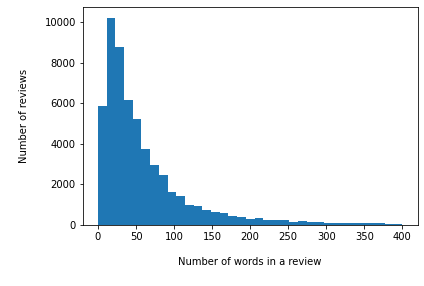

Reviews longer than 80 words : 12704
Reviews in total: 55824
Percentage of reviews with more than 80 words: 18.20578962453425 %


In [535]:
# determining the sequence length

# count the reviews that are longer than 100 words
nr_reviews_merged_long = sum(i > 80 for i in nr_words_merged)

# create a histogram
plt.hist(nr_words_merged, bins = 35, range = (0,400))
plt.xlabel('\nNumber of words in a review\n', fontsize = 10)
plt.ylabel('\nNumber of reviews\n', fontsize = 10)
plt.show()

# print calculated numbers for longer sequences
print("Reviews longer than 80 words : "+ str(nr_reviews_merged_long))
print("Reviews in total: "+ str(len(nr_words_merged)))
print("Percentage of reviews with more than 80 words: "+str((nr_reviews_merged_long/len(nr_words_merged))*80)+' %')

In [536]:
# determining the vocabulary size

# print the full vocabulary size
print("Full vocabulary size: " + str(len(word_freqs_merged)))

# determine how many words make up the 25000 most commonly used words
vocab_words_total_merged = sum(list(word_freqs_merged.values())[:65000])

# determine total words 
words_total_merged = sum(list(word_freqs_merged.values()))

# print the percentage of words covered by a vocabulary of 25000
print('Percentage of words covered by vocabulary: ' + str(vocab_words_total_merged/words_total_merged))

Full vocabulary size: 105039
Percentage of words covered by vocabulary: 0.9579399973582232


In [530]:
# set the vocabulary size and the sequence length
vocab_size = 65000
seq_len = 50

## Word embedding preparation and padding sequences

In [531]:
# prepare the lookup-table id2word using the vocabulary
# id2word maps word ids to written words
# PAD token has id 0, UNK token has id 1

word2id = {}
word2id["PAD"] = 0
word2id["UNK"] = 1
for v, (k, _) in enumerate(word_freqs_merged.most_common(vocab_size - 2)):
    word2id[k] = v + 2
id2word = {v:k for k, v in word2id.items()}

In [532]:
# function for checking if a word is contained in the vocabulary, otherwise UNK token


# function for loading the word embeddings into the matrix embedding in a sorted way
# word embedding for word with id 0 constitutes the starting row in the matrix, etc.
def load_vectors(embedding_file, word2id, embed_size):
    embedding = np.zeros((len(word2id), embed_size))
    file = open(embedding_file, encoding="utf8")
    for line in file:
        cols = line.strip().split()
        word = cols[0]
        if embed_size == 0:
            embed_size = len(cols) - 1
        if word in word2id:
            vec = np.array([float(v) for v in cols[1:]])
            embedding[lookup_word2id(word)] = vec
    embedding[word2id["PAD"]] = np.zeros((embed_size))
    embedding[word2id["UNK"]] = unk
    # for first time execution:
    # embedding[word2id["UNK"]] = np.random.uniform(-1, 1, embed_size)
    
    return embedding

# function for assigning the word embeddings to the word ids in the sequences
# resulting embbedding array emb is of shape (data.shape[0], maxlen, embedding_dim)
def assign_wordvectors(parsed_ids, dict_emb):
    
    emb = np.copy(parsed_ids).astype(int)
    emb = list(emb.flatten())
    emb = np.array([*map(dict_emb.get, emb)])
    emb = emb.reshape((parsed_ids.shape[0], seq_len, 300))
    
    return emb

In [533]:
# encode the words to ids and pad them for train and test data
#parsed_ids_train = [[lookup_word2id(w) for w in s.split()] for s in parsed_reviews_train]
#parsed_ids_train = sequence.pad_sequences(parsed_ids_train, 100)
parsed_ids_merged = [[lookup_word2id(w) for w in s.split()] for s in parsed_reviews_merged]
parsed_ids_merged = sequence.pad_sequences(parsed_ids_merged, 50)
parsed_ids_test = [[lookup_word2id(w) for w in s.split()] for s in parsed_reviews_test]
parsed_ids_test = sequence.pad_sequences(parsed_ids_test, 50)

# load the embeddings into an embedding matrix using the word2id lookup-table
# embeddings are loaded exactly in order of the ids
embeddings = load_vectors('wiki-news-300d-1M.vec', word2id, 300)

# creating an embedding dictionary of word vectors from the embedding matrix
# keys are ids and values are word embeddings
dict_emb = dict((j, embeddings[j])for j in range(embeddings.shape[0]))

# assign word embeddings to train and test data
#data_emb_train = assign_wordvectors(parsed_ids_train, dict_emb) 
data_emb_merged = assign_wordvectors(parsed_ids_merged, dict_emb) 
data_emb_test = assign_wordvectors(parsed_ids_test, dict_emb) 


In [ ]:
data_emb_merged.shape

In [534]:
# save preprocessed data to files
#f = h5py.File('data/fully_preprocessed_data/X_train_preprocessed.h5','a')
#f.create_dataset('data',data=data_emb_train)
#f.close()
h = h5py.File('data/fully_preprocessed_data/X_merged_preprocessed_new14.h5','a')
h.create_dataset('data',data=data_emb_merged)
h.close()

g = h5py.File('data/fully_preprocessed_data/X_test_preprocessed_new14.h5','a')
g.create_dataset('data',data=data_emb_test)
g.close()


#pkl.dump(np.array([y_train,domain_train,idx_domain_train]), open("domain_and_label_train.p", "wb"))
pkl.dump(np.array([y_merged,domain_merged,idx_domain_merged]), open("domain_and_label_merged14.p", "wb"))
pkl.dump(np.array([y_test,domain_test,idx_domain_test]), open("domain_and_label_test14.p", "wb"))
